In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, classification_report

from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator

from util import compute_cuts  # deve estar no mesmo diretório

CSV_PATH = "weatherAUS.csv"

/home/murilob/codes/predict-rain-australia/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def carregar_e_filtrar():
    df = pd.read_csv(CSV_PATH)

    vars_keep = [
        "Humidity3pm",
        "Sunshine",
        "Cloud3pm",
        "Rainfall",
        "Pressure9am",
        "WindGustSpeed",
        "Humidity9am",
        "Cloud9am",
        "WindGustDir",
        "RainTomorrow",
    ]

    vars_to_drop = df.columns.difference(vars_keep)
    df.drop(columns=vars_to_drop, inplace=True)

    total_antes = len(df)
    df.dropna(
        subset=[
            "RainTomorrow",
            "Humidity3pm",
            "Rainfall",
            "Pressure9am",
            "WindGustSpeed",
            "Humidity9am",
            "WindGustDir",
        ],
        inplace=True,
    )
    total_depois = len(df)

    print(f"Total antes da remoção de NaNs: {total_antes}")
    print(f"Total depois da remoção de NaNs: {total_depois}")

    df["RainTomorrow"] = df["RainTomorrow"].map({"No": 0, "Yes": 1}).astype("category")

    return df

In [3]:
def discretizar_treinoteste(train_df: pd.DataFrame, test_df: pd.DataFrame):

    for var in train_df.columns.to_list():
        if var == "RainTomorrow":
            continue

        if train_df[var].dtype != "object":  # numérica
            df_clean = train_df.dropna(subset=[var, "RainTomorrow"])

            thresholds = compute_cuts(
                df_clean[var].to_frame(), df_clean["RainTomorrow"], max_leaf_nodes=3
            )

            print(f"Thresholds para {var}: {thresholds}")

            # Aplicar cortes
            train_bins = pd.cut(
                train_df[var],
                bins=[-np.inf] + thresholds.tolist() + [np.inf],
                labels=False,
            )

            test_bins = pd.cut(
                test_df[var],
                bins=[-np.inf] + thresholds.tolist() + [np.inf],
                labels=False,
            )

            train_df[var] = train_bins.astype("category")
            test_df[var] = test_bins.astype("category")

            # Categorias para Missing
            if var in ["Cloud3pm", "Cloud9am", "Sunshine"]:
                train_df[var] = train_df[var].cat.add_categories(["Missing"])
                test_df[var] = test_df[var].cat.add_categories(["Missing"])

                train_df.loc[train_df[var].isna(), var] = "Missing"
                test_df.loc[test_df[var].isna(), var] = "Missing"

            # Converte para string
            train_df[var] = train_df[var].astype(str)
            test_df[var] = test_df[var].astype(str)

    return train_df, test_df

In [4]:
def definir_estrutura():
    return [
        ("Humidity3pm", "RainTomorrow"),
        ("Sunshine", "RainTomorrow"),
        ("Cloud3pm", "RainTomorrow"),
        ("Rainfall", "RainTomorrow"),
        ("Pressure9am", "RainTomorrow"),
        ("WindGustSpeed", "RainTomorrow"),
        ("Humidity9am", "Humidity3pm"),
        ("Cloud9am", "Cloud3pm"),
        ("Pressure9am", "WindGustSpeed"),
        ("WindGustDir", "WindGustSpeed"),
    ]


def treinar_modelo(train_df: pd.DataFrame):
    edges = definir_estrutura()
    model = DiscreteBayesianNetwork(edges)

    model.fit(train_df, estimator=MaximumLikelihoodEstimator)
    assert model.check_model()

    print("CPT da variável RainTomorrow:")
    display(model.get_cpds("RainTomorrow").to_dataframe())

    return model

In [5]:
def avaliar_modelo(model: DiscreteBayesianNetwork, test_df: pd.DataFrame):

    x_test = test_df.drop(columns=["RainTomorrow"])
    y_test = test_df["RainTomorrow"]

    y_probs_df = model.predict_probability(x_test)
    probs_chuva = y_probs_df.iloc[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test.astype(int), probs_chuva)
    auc_score = roc_auc_score(y_test.astype(int), probs_chuva)

    print(f"AUC Score: {auc_score:.4f}")

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
    plt.plot([0, 1], [0, 1], "k--", label="Aleatório")

    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("Curva ROC")
    plt.legend()
    plt.grid()
    plt.show()

    # Melhor threshold (Youden)
    J = tpr - fpr
    ix = np.argmax(J)

    print(f"Melhor Threshold: {thresholds[ix]}")
    print(f"Sensibilidade: {tpr[ix]}")
    print(f"Falso Alarme: {fpr[ix]}")

    y_pred_otimizado = (probs_chuva >= thresholds[ix]).astype(int)
    print(classification_report(y_test.astype(int), y_pred_otimizado))

In [6]:
def plotar_estrutura(model: DiscreteBayesianNetwork):

    G = nx.DiGraph()
    G.add_edges_from(model.edges())

    plt.figure(figsize=(16, 12))

    primary = [
        "Cloud3pm",
        "Sunshine",
        "Humidity3pm",
        "Rainfall",
        "Pressure9am",
        "WindGustSpeed",
    ]
    secondary = ["Cloud9am", "Humidity9am", "WindGustDir"]

    pos = {}
    pos["RainTomorrow"] = (0, 0)

    angle_step = 2 * np.pi / len(primary)
    radius1 = 2

    for i, node in enumerate(primary):
        angle = i * angle_step
        pos[node] = (radius1 * np.cos(angle), radius1 * np.sin(angle))

    angle_step = 2 * np.pi / len(secondary)
    radius2 = 4

    for i, node in enumerate(secondary):
        angle = i * angle_step + 0.4
        pos[node] = (radius2 * np.cos(angle), radius2 * np.sin(angle))

    node_colors = [
        (
            "lightcoral"
            if n == "RainTomorrow"
            else (
                "lightskyblue"
                if n in primary
                else "lightgreen" if n in secondary else "lightgray"
            )
        )
        for n in G.nodes()
    ]

    nx.draw(
        G,
        pos,
        node_color=node_colors,
        node_size=5000,
        font_size=9,
        arrows=True,
        arrowsize=20,
        edge_color="gray",
        arrowstyle="->",
    )

    label_offset = 0.12

    for node, (x, y) in pos.items():
        if node in ["RainTomorrow", "WindGustSpeed"]:
            pos[node] = (x, y - label_offset)

    nx.draw_networkx_labels(G, pos, font_size=12, font_weight="bold")

    plt.title("Estrutura da Rede Bayesiana", fontsize=16)
    plt.tight_layout()
    plt.show()

Total antes da remoção de NaNs: 145460
Total depois da remoção de NaNs: 119788
Thresholds para Rainfall: [0.35000001 5.95000005]
Thresholds para Sunshine: [7.54999995 9.55000019]
Thresholds para WindGustSpeed: [47. 58.]
Thresholds para Humidity9am: [59.5 73.5]
Thresholds para Humidity3pm: [66.5 81.5]
Thresholds para Pressure9am: [1008.8500061  1014.54998779]
Thresholds para Cloud9am: [4.5 7.5]
Thresholds para Cloud3pm: [5.5 7.5]


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Rainfall': 'C', 'Sunshine': 'C', 'WindGustDir': 'C', 'WindGustSpeed': 'C', 'Humidity9am': 'C', 'Humidity3pm': 'C', 'Pressure9am': 'C', 'Cloud9am': 'C', 'Cloud3pm': 'C', 'RainTomorrow': 'C'}


CPT da variável RainTomorrow:


RainTomorrow                                                             0  \
Cloud3pm Humidity3pm Pressure9am Rainfall Sunshine WindGustSpeed             
0.0      0           0           0        0.0      0              0.738095   
                                                   1              0.551724   
                                                   2              0.508772   
                                          1.0      0              0.787234   
                                                   1              0.820513   
...                                                                    ...   
Missing  2           2           2        2.0      1              0.500000   
                                                   2              0.500000   
                                          Missing  0              0.193548   
                                                   1              0.076923   
                                                   2              0.037037   

RainTomorrow                                                             1  
Cloud3pm Humidity3pm Pressure9am Rainfall Sunshine WindGustSpeed            
0.0      0           0           0        0.0      0              0.261905  
                                                   1              0.448276  
                                                   2              0.491228  
                                          1.0      0              0.212766  
                                                   1              0.179487  
...                                                                    ...  
Missing  2           2           2        2.0      1              0.500000  
                                                   2              0.500000  
                                          Missing  0              0.806452  
                                                   1              0.923077  
                                                   2              0.962963  

[1296 rows x 2 columns]

AUC Score: 0.8442


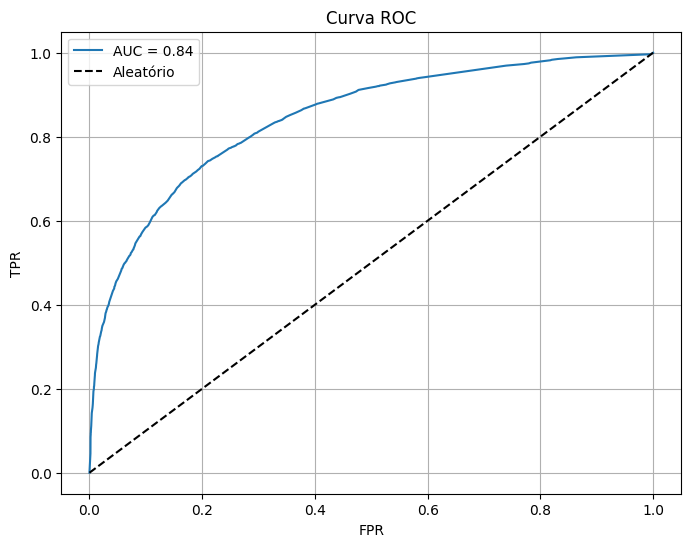

Melhor Threshold: 0.2169811320754717
Sensibilidade: 0.7417446077495705
Falso Alarme: 0.2100005342165714
              precision    recall  f1-score   support

           0       0.92      0.79      0.85     18719
           1       0.50      0.74      0.60      5239

    accuracy                           0.78     23958
   macro avg       0.71      0.77      0.72     23958
weighted avg       0.82      0.78      0.79     23958



/tmp/ipykernel_17859/2201293666.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


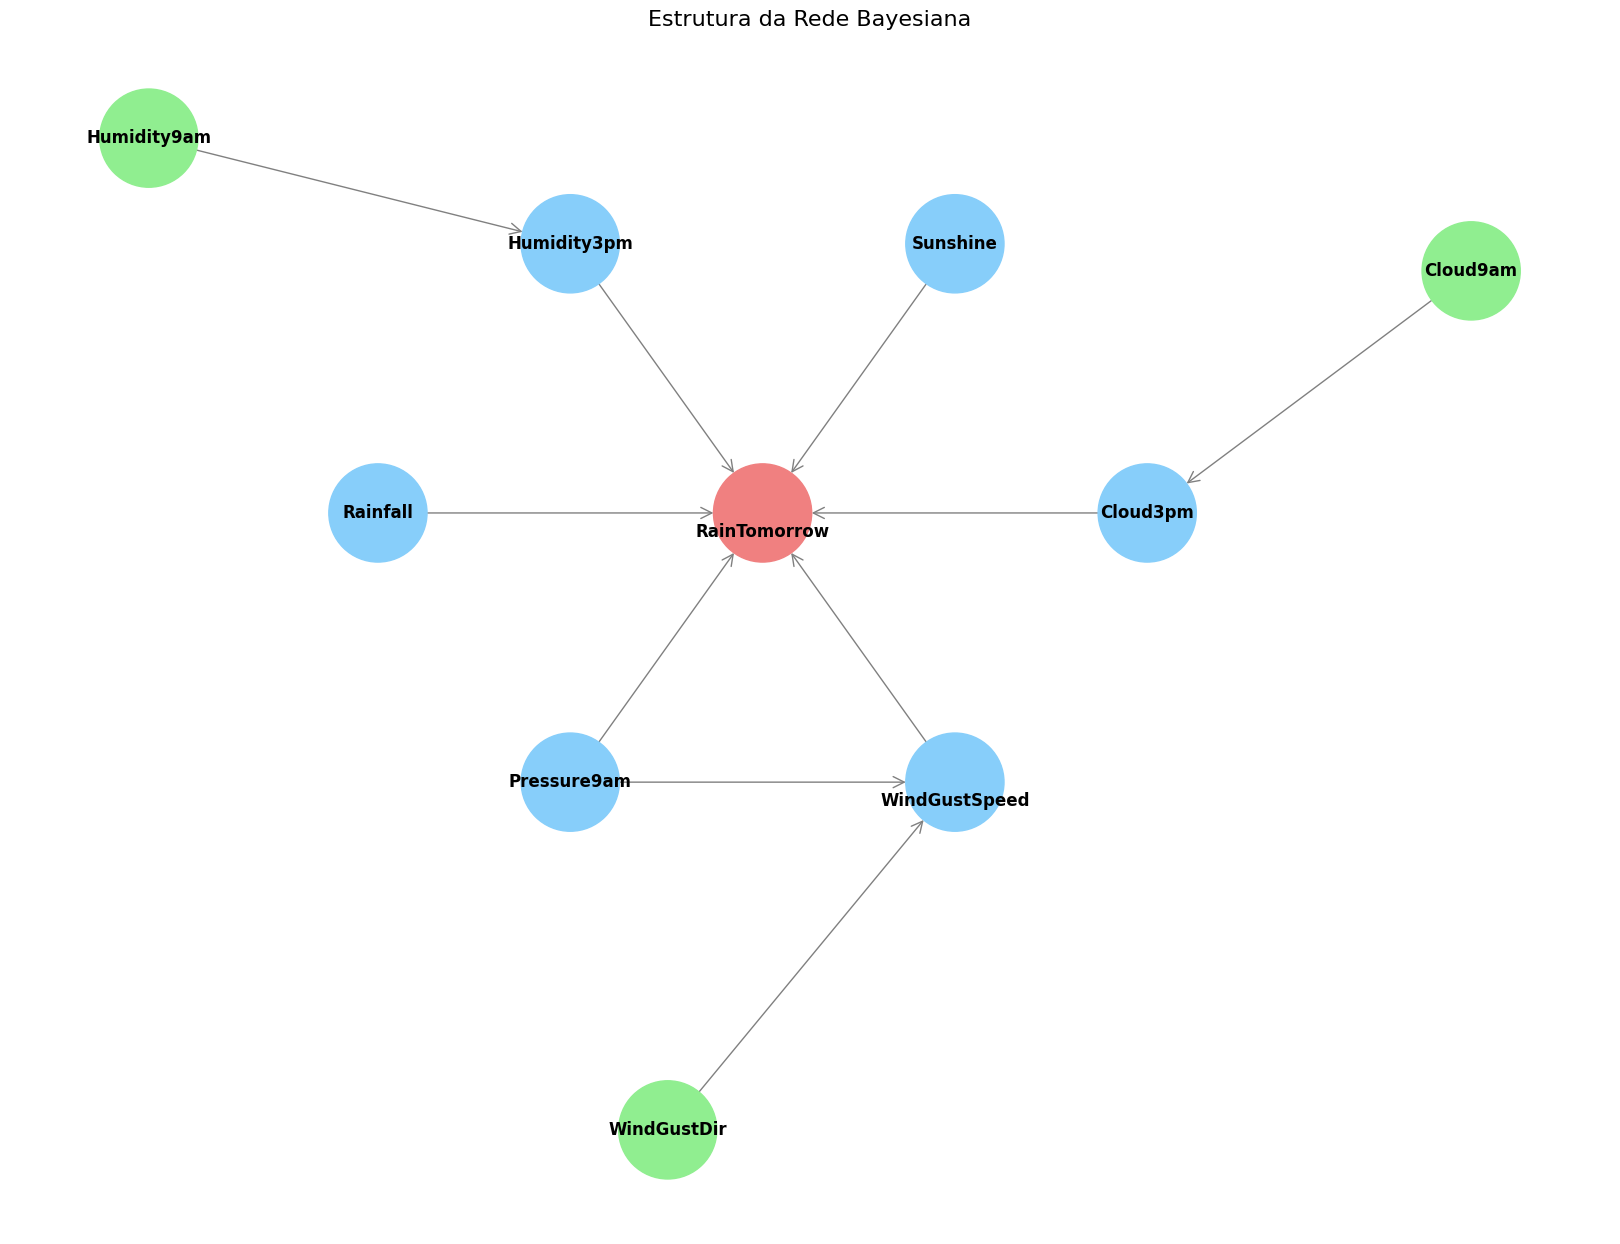

In [7]:
df = carregar_e_filtrar()

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, test_df = discretizar_treinoteste(train_df, test_df)

model = treinar_modelo(train_df)

avaliar_modelo(model, test_df)

plotar_estrutura(model)